#Separation of CIFAR-10 Images

The model takes as input an image created by averaging two random samples from CIFAR-10 and is tasked with predicting the categories of the two components.

The first image belongs to the first five categories (airplane, automobile, bird, cat, deer), while the second belongs to the remaining categories (dog, frog, horse, ship, truck). The model must return two labels, each within a range of five possible values.

The evaluation metric for the model is as follows: calculate the classification accuracy for the two component images and then compute their average.

The metric should be evaluated on 10,000 inputs generated from test data. Repeat the calculation 10 times and measure the standard deviation, which must be reported.

A data generator and some examples are provided below.

#Data preparation

In [65]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import numpy as np
from matplotlib import pyplot as plt

In [66]:
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()

# Ensures the data has expected dimensions.
assert cifar10_x_train.shape == (50000, 32, 32, 3)
assert cifar10_x_test.shape == (10000, 32, 32, 3)
assert cifar10_y_train.shape == (50000, 1)
assert cifar10_y_test.shape == (10000, 1)

# Class labels for CIFAR-10 dataset
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Scales pixel values to [0, 1] for better model performance.
cifar10_x_train = (cifar10_x_train/255.).astype(np.float32)
cifar10_x_test = (cifar10_x_test/255.).astype(np.float32)

Let us split the images in two groups, according to their label.

In [67]:
# Separates training data into Group 1 (classes 0-4) and Group 2 (classes 5-9).
# Split training data based on class labels (<5 and >=5)
cond_1 = cifar10_y_train[:,0] < 5
cifar10_x_train_1 = cifar10_x_train[cond_1]
cifar10_y_train_1 = cifar10_y_train[cond_1]

cond_2 = cifar10_y_train[:,0] >= 5
cifar10_x_train_2 = cifar10_x_train[cond_2]
cifar10_y_train_2 = cifar10_y_train[cond_2]

# Separates testing data into Group 1 (classes 0-4) and Group 2 (classes 5-9).
# Split test data based on class labels (<5 and >=5)
cond_1_test = cifar10_y_test[:,0] < 5
cifar10_x_test_1 = cifar10_x_test[cond_1_test]
cifar10_y_test_1 = cifar10_y_test[cond_1_test]

cond_2_test = cifar10_y_test[:,0] >= 5
cifar10_x_test_2 = cifar10_x_test[cond_2_test]
cifar10_y_test_2 = cifar10_y_test[cond_2_test]

Now we can define the generator. The input consists of two datasets (X1,X2), their corresponding labels (Y1,Y2), and a batch size.

The generator returns (x_data,y_data), where:
* x_data is a batch of images obtained by averaging random samples from X1 and X2.
* y_data is a pair of batches of labels corresponding to the component images, expressed in categorical format.

In [68]:
# Data generator function to create mixed batches of samples from two subsets
def datagenerator(X1,X2,Y1,Y2,batchsize):
  size1 = X1.shape[0]
  size2 = X2.shape[0]
  Y1_cat = tf.keras.utils.to_categorical(Y1, num_classes=5)
  Y2_cat = tf.keras.utils.to_categorical(Y2-5, num_classes=5)
  # Convert labels to one-hot encoding
  while True:
    # Randomly sample indices for both subsets
    num1 = np.random.randint(0, size1, batchsize)
    num2 = np.random.randint(0, size2, batchsize)
    
    # Combine samples from both subsets
    x_data = (X1[num1] + X2[num2]) / 2.0
    y_data = (Y1_cat[num1],Y2_cat[num2])

    yield x_data, y_data


Let us instantiate a generator on Cifar10 with batchsize=1, and let's see its behaviour.

In [69]:
# Tests the generator by visualizing a sample mixed image and its predicted labels.
datagen = datagenerator(cifar10_x_train_1,cifar10_x_train_2,cifar10_y_train_1,cifar10_y_train_2,1)

Let's generate an example, display the image that the model will take as input, and print the categories of the two overlapping components.

You can re-run the cell to display new examples.

first: cat, second = frog


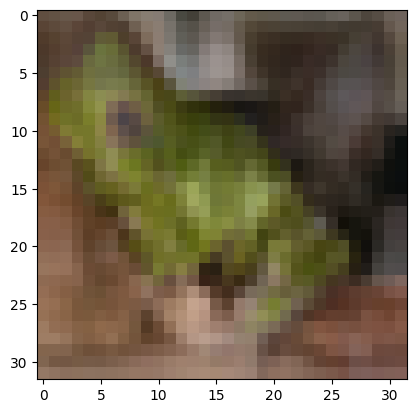

In [70]:
# Test the generator
x, y = next(datagen)

print("first: {}, second = {}".format(classes[np.argmax(y[0][0])],classes[np.argmax(y[1][0])+5]))
#print(np.min(x[0]),np.max(x[0]))
plt.imshow(x[0])

# Model Evaluation

Let us define first of all the test generator.

In [71]:
# Generate test samples for evaluation
testgen = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2,10000)
eval_samples_x, eval_samples_y = next(testgen)
print(eval_samples_x.shape)
# Ensure the batch size matches your evaluation needs.

(10000, 32, 32, 3)


We now test a model producing random guesses. You will need to replace it with your own predictive model.

In [72]:
# Modify ---------------Replace this with your actual model--------------


# Define the predictive model
def predictive_model():
    # Input layer
    input_layer = layers.Input(shape=(32, 32, 3))

    # Shared Convolutional Layers
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_layer)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.GlobalAveragePooling2D()(x)

    # First output (classes 0-4)
    output_1 = layers.Dense(5, activation="softmax", name="output_1")(x)

    # Second output (classes 5-9)
    output_2 = layers.Dense(5, activation="softmax", name="output_2")(x)

    # Create the model
    model = Model(inputs=input_layer, outputs=[output_1, output_2])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss={
            "output_1": "categorical_crossentropy",
            "output_2": "categorical_crossentropy",
        },
        metrics={"output_1": "accuracy", "output_2": "accuracy"},
    )
    return model


# Instantiate the model
model = predictive_model()

# Train the model using the generator
batch_size = 64
steps_per_epoch = 50000 // batch_size
validation_steps = 10000 // batch_size

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

history = model.fit(
    datagenerator(
        cifar10_x_train_1,
        cifar10_x_train_2,
        cifar10_y_train_1,
        cifar10_y_train_2,
        batch_size,
    ),
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=datagenerator(
        cifar10_x_test_1,
        cifar10_x_test_2,
        cifar10_y_test_1,
        cifar10_y_test_2,
        batch_size,
    ),
    validation_steps=validation_steps,
    callbacks=[early_stopping],
)

Epoch 1/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - loss: 2.9997 - output_1_accuracy: 0.3187 - output_1_loss: 1.5058 - output_2_accuracy: 0.3248 - output_2_loss: 1.4939 - val_loss: 2.7231 - val_output_1_accuracy: 0.3835 - val_output_1_loss: 1.3848 - val_output_2_accuracy: 0.4322 - val_output_2_loss: 1.3383
Epoch 2/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - loss: 2.6420 - output_1_accuracy: 0.4219 - output_1_loss: 1.3587 - output_2_accuracy: 0.4687 - output_2_loss: 1.2833 - val_loss: 2.4974 - val_output_1_accuracy: 0.4539 - val_output_1_loss: 1.2874 - val_output_2_accuracy: 0.5101 - val_output_2_loss: 1.2100
Epoch 3/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - loss: 2.5223 - output_1_accuracy: 0.4493 - output_1_loss: 1.3105 - output_2_accuracy: 0.5055 - output_2_loss: 1.2118 - val_loss: 2.4186 - val_output_1_accuracy: 0.4889 - val_output_1_loss: 1.2484 - val_output_2_accuracy: 0.5244 - val_output_2_loss: 1.1701
Epoch 4/10
781/781 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - loss: 2.

In [73]:
# Modify ------------Refactor if additional metrics are needed--------------

# Evaluation function for models
def eval_model(model):
    eval_samples_x, eval_samples_y = next(testgen)
    predictions = model.predict(eval_samples_x)
    # Extract predictions for both outputs
    pred_output_1 = np.argmax(predictions[0], axis=1)
    pred_output_2 = np.argmax(predictions[1], axis=1)
    
    # Calculate accuracy for both outputs
    correct_guesses_1 = pred_output_1 == np.argmax(eval_samples_y[0], axis=1)
    correct_guesses_2 = pred_output_2 == np.argmax(eval_samples_y[1], axis=1)

    return (np.mean(correct_guesses_1) + np.mean(correct_guesses_2)) / 2

In [74]:
# ------------------------------------------------------------------------------------
average_accuracy = eval_model(model)
print(f"Average accuracy: {average_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Average accuracy: 0.5672999999999999


As expected, the accuracy is around 1/5 = 0.2

Let us repeat the evaluation ten times, and compute the standard deviation

In [75]:
# Evaluate the random model
repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
  eval_results.append(eval_model(model))
print("mean accuracy = ", np.mean(eval_results))
print("standard deviation = ", np.std(eval_results))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
mean accuracy =  0.5618049999999999
standard deviation =  0.004627388572402365


In [76]:
model.save_weights('cifar10_model.weights.h5')

# What to Submit

As usual, you need to submit a single notebook that must be executable on Colab. The notebook should be properly commented and include a complete record of the training process, as well as the calculation of accuracy according to the guidelines provided above.

# Good luck!

